In [176]:
import os
import re
import sys
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

# os.environ["ICTDIR"] = "~/Packages/IC"
# os.environ["ICDIR"] = "$ICTDIR/invisible_cities;"

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer
%config InlineBackend.figure_format = 'svg'


In [177]:
# Load in the files
lt_dir = os.path.expandvars("../../files/next100/NEXT100_S2_LT/")
# lt_dir = os.path.expandvars("../config/")
lt_filenames = glob.glob(os.path.join(lt_dir, "*.h5"))
lt_filenames = sorted(lt_filenames)
print(lt_filenames)

# Configure the detector database
detector_db = "next100"
datapmt = load_db.DataPMT(detector_db, 0)
xpmt, ypmt = datapmt["X"].values, datapmt["Y"].values
sensorids  = datapmt["SensorID"].values

['../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_0.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1000.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1001.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1002.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1003.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1004.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1005.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1006.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1007.h5', '../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_1008.h5']


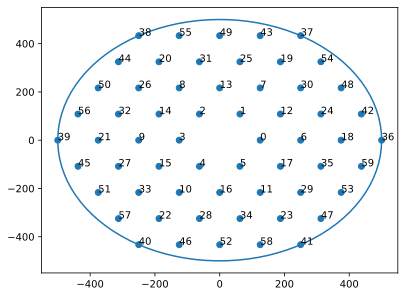

In [189]:
plt.scatter(xpmt, ypmt)
for x, y, sid  in zip(xpmt, ypmt, sensorids):
    plt.annotate(sid, (x, y))

r = 500
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

In [179]:
filename = lt_filenames[0]
print(filename)
parts = pd.read_hdf(filename, 'MC/particles')
parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]
display(parts.head(10))


../../files/next100/NEXT100_S2_LT/NEXT100_S2_LT_738863_0.h5


event_id   initial_x   initial_y  initial_z
0       100  158.246918  -74.972870  -6.855349
1       101   24.295834   79.895439  -5.439569
2       102 -122.814430  236.451813  -6.458309
3       103  -96.491776  373.019409  -3.501778
4       104   37.889790  318.919189  -4.758223
5       105  385.906036  -59.197983  -5.359226
6       106 -212.970596   70.717018  -6.437752
7       107 -363.532196  325.102112  -0.873390
8       108  179.867783 -327.435303  -8.588251
9       109  105.084122 -158.042770  -7.644829

In [180]:
# Get the metadata from the files
configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
num_events = int(configuration.loc["num_events"][0])
nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

sns_response  = pd.read_hdf(filename, "MC/sns_response")
pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]

pd.set_option('display.max_rows', None)
# display(pmt_response)
display(pmt_response.head(20))

event_id  sensor_id  time_bin  charge
0        100         35         0     174
1        100         35         1      22
2        100         45         0     179
3        100         45         1      21
4        100         45         2       2
5        100          0         0     220
6        100          0         1      24
7        100          0         2       2
8        100         51         0     187
9        100         51         1      36
10       100         47         0     196
11       100         47         1      23
12       100         47         2       3
13       100         20         0     183
14       100         20         1      30
15       100         20         2       5
16       100         29         0     180
17       100         29         1      14
18       100         19         0     161
19       100         19         1      36

In [181]:
# protection time bins
pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()
display(pmt_response.head(20))

sensor_id  event_id  charge
0           0       100     246
1           0       101     198
2           0       102     199
3           0       103     183
4           0       104     214
5           0       105     182
6           0       106     201
7           0       107     134
8           0       108     215
9           0       109     220
10          0       110     214
11          0       111     193
12          0       112     206
13          0       113     196
14          0       114     184
15          0       115     192
16          0       116     205
17          0       117     172
18          0       118     203
19          0       119     212

In [182]:
# Merge the dataframes to add the x, y, z positions
pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')
display(pmt_response.head(20))

sensor_id  event_id  charge   initial_x  initial_y  initial_z
0           0       100     246  158.246918  -74.97287  -6.855349
1           1       100     242  158.246918  -74.97287  -6.855349
2           2       100     234  158.246918  -74.97287  -6.855349
3           3       100     217  158.246918  -74.97287  -6.855349
4           4       100     204  158.246918  -74.97287  -6.855349
5           5       100     224  158.246918  -74.97287  -6.855349
6           6       100     206  158.246918  -74.97287  -6.855349
7           7       100     231  158.246918  -74.97287  -6.855349
8           8       100     237  158.246918  -74.97287  -6.855349
9           9       100     256  158.246918  -74.97287  -6.855349
10         10       100     189  158.246918  -74.97287  -6.855349
11         11       100     228  158.246918  -74.97287  -6.855349
12         12       100     218  158.246918  -74.97287  -6.855349
13         13       100     211  158.246918  -74.97287  -6.855349
14         14       100     227  158.246918  -74.97287  -6.855349
15         15       100     218  158.246918  -74.97287  -6.855349
16         16       100     198  158.246918  -74.97287  -6.855349
17         17       100     233  158.246918  -74.97287  -6.855349
18         18       100     207  158.246918  -74.97287  -6.855349
19         19       100     199  158.246918  -74.97287  -6.855349

In [183]:
# Set the Binning
xmin=-500
xmax=500
xbw=20

# zmin=0
# zmax=510
# zbw=25

zmin=-12
zmax=2
zbw=11

xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = xbins
zbins = np.arange(zmin, zmax+zbw, zbw)

xbins_centre = np.arange(xmin+xbw/2, xmax+xbw/2, xbw)
ybins_centre = xbins_centre
zbins_centre = np.arange(zmin+zbw/2, zmax+zbw/2, zbw)

print(zbins)
print(zbins_centre)



[-12  -1  10]
[-6.5  4.5]


In [184]:
# Now bin the x, y, z positions
pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

# remove the initial x,y,z since we are done with them
pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])
# display(pmt_response)
# display(pmt_response.loc[pmt_response['sensor_id'] == 0])

In [185]:
# Normalise the charge in each PMT by the total number of photons simulated
pmt_response['charge'] = pmt_response['charge']/nphotons

LT = pmt_response

LT  = pd.pivot_table(pmt_response , values="charge", columns="sensor_id", index=["x", "y", "z"])

display(LT.head(20))

sensor_id                 0         1         2         3         4   \
x      y      z                                                        
-490.0 -50.0  -6.5  0.000068  0.000069  0.000065  0.000065  0.000056   
-450.0 -110.0 4.5   0.000198  0.000185  0.000165  0.000185  0.000187   
       190.0  -6.5  0.000093  0.000097  0.000101  0.000082  0.000092   
-430.0 -110.0 -6.5  0.000176  0.000171  0.000198  0.000188  0.000193   
-410.0 -110.0 -6.5  0.000177  0.000161  0.000196  0.000190  0.000197   
       -250.0 -6.5  0.000151  0.000147  0.000144  0.000155  0.000155   
-390.0 -50.0  -6.5  0.000205  0.000205  0.000218  0.000205  0.000212   
       10.0   -6.5  0.000208  0.000192  0.000210  0.000203  0.000181   
       250.0  -6.5  0.000175  0.000179  0.000170  0.000160  0.000182   
-370.0 -150.0 -6.5  0.000192  0.000190  0.000195  0.000199  0.000210   
       50.0   -6.5  0.000216  0.000211  0.000193  0.000199  0.000213   
       330.0  4.5   0.000134  0.000106  0.000144  0.000104  0.000112   
-350.0 70.0   -6.5  0.000210  0.000191  0.000212  0.000208  0.000205   
-330.0 150.0  -6.5  0.000193  0.000191  0.000194  0.000210  0.000198   
-310.0 -270.0 -6.5  0.000186  0.000185  0.000178  0.000191  0.000182   
-290.0 10.0   -6.5  0.000203  0.000234  0.000228  0.000208  0.000215   
       -210.0 -6.5  0.000210  0.000213  0.000189  0.000189  0.000206   
-270.0 250.0  -6.5  0.000213  0.000202  0.000199  0.000206  0.000224   
-250.0 -50.0  -6.5  0.000230  0.000203  0.000217  0.000179  0.000213   
       70.0   -6.5  0.000235  0.000216  0.000207  0.000197  0.000187   

sensor_id                 5         6         7         8         9   ...  \
x      y      z                                                       ...   
-490.0 -50.0  -6.5  0.000074  0.000060  0.000057  0.000061  0.000059  ...   
-450.0 -110.0 4.5   0.000199  0.000179  0.000168  0.000177  0.000163  ...   
       190.0  -6.5  0.000104  0.000101  0.000083  0.000122  0.000103  ...   
-430.0 -110.0 -6.5  0.000160  0.000176  0.000188  0.000175  0.000186  ...   
-410.0 -110.0 -6.5  0.000212  0.000174  0.000189  0.000176  0.000208  ...   
       -250.0 -6.5  0.000139  0.000130  0.000137  0.000139  0.000151  ...   
-390.0 -50.0  -6.5  0.000202  0.000181  0.000201  0.000201  0.000188  ...   
       10.0   -6.5  0.000219  0.000205  0.000189  0.000187  0.000192  ...   
       250.0  -6.5  0.000163  0.000157  0.000165  0.000159  0.000165  ...   
-370.0 -150.0 -6.5  0.000209  0.000219  0.000168  0.000201  0.000224  ...   
       50.0   -6.5  0.000201  0.000185  0.000167  0.000211  0.000229  ...   
       330.0  4.5   0.000125  0.000119  0.000104  0.000111  0.000140  ...   
-350.0 70.0   -6.5  0.000221  0.000207  0.000227  0.000212  0.000203  ...   
-330.0 150.0  -6.5  0.000210  0.000204  0.000181  0.000224  0.000199  ...   
-310.0 -270.0 -6.5  0.000188  0.000185  0.000175  0.000185  0.000192  ...   
-290.0 10.0   -6.5  0.000208  0.000205  0.000207  0.000207  0.000208  ...   
       -210.0 -6.5  0.000205  0.000185  0.000204  0.000206  0.000192  ...   
-270.0 250.0  -6.5  0.000198  0.000227  0.000178  0.000201  0.000218  ...   
-250.0 -50.0  -6.5  0.000236  0.000208  0.000198  0.000228  0.000209  ...   
       70.0   -6.5  0.000201  0.000218  0.000219  0.000210  0.000214  ...   

sensor_id                 50        51        52        53        54  \
x      y      z                                                        
-490.0 -50.0  -6.5  0.000064  0.000070  0.000058  0.000054  0.000063   
-450.0 -110.0 4.5   0.000171  0.000185  0.000153  0.000178  0.000162   
       190.0  -6.5  0.000107  0.000105  0.000100  0.000094  0.000094   
-430.0 -110.0 -6.5  0.000200  0.000182  0.000179  0.000192  0.000166   
-410.0 -110.0 -6.5  0.000222  0.000199  0.000166  0.000193  0.000190   
       -250.0 -6.5  0.000146  0.000122  0.000129  0.000148  0.000140   
-390.0 -50.0  -6.5  0.000235  0.000200  0.000205  0.000202  0.000191   
       10.0   -6.5  0.000206  0.000183  0.000196  0.000183  0.000230   


In [186]:
LT  = pd.DataFrame()
ERR = pd.DataFrame()

for i, filename in enumerate(lt_filenames, 1):
    sys.stdout.write(f"Processing file {i}/{len(lt_filenames)} \r")
    sys.stdout.flush()
    
    configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
    num_events = int(configuration.loc["num_events"][0])
    nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

    sns_response  = pd.read_hdf(filename, "MC/sns_response")
    pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]
    
    # protection time bins
    pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()

    # Load in the MC Particles
    parts = pd.read_hdf(filename, 'MC/particles')
    parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]

    # Merge the dataframes
    pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')

    # Now bin the x, y, z positions
    pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
    pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
    pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

    # remove the initial x,y,z since we are done with them
    pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

    # Normalise the charge in each PMT by the total number of photons simulated
    pmt_response['charge'] = pmt_response['charge']/nphotons
    
    LT  = pd.concat([LT , pmt_response])
    ERR = pd.concat([LT, pmt_response])



In [187]:
# lt = LT.groupby(["sensor_id", "x", "y", "z"])["charge"].mean().to_frame().reset_index()
# err = ERR.groupby(["sensor_id", "x", "y", "z"])["charge"].std().to_frame().reset_index()

lt = LT.groupby(["sensor_id", "x", "y"])["charge"].mean().to_frame().reset_index()
err = ERR.groupby(["sensor_id", "x", "y"])["charge"].std().to_frame().reset_index()

# Calculate error values
err['charge'] = 100*err['charge']/lt['charge']

# display(lt.head(10))
# display(err.head(10))

display(lt[lt.charge>0].head(10))
display(err[err.charge>0].head(10))

sensor_id      x      y    charge
21          0 -490.0  -70.0  0.000126
22          0 -490.0  -50.0  0.000068
23          0 -490.0  -30.0  0.000128
25          0 -490.0   10.0  0.000074
26          0 -490.0   30.0  0.000122
27          0 -490.0   50.0  0.000108
28          0 -490.0   70.0  0.000119
69          0 -470.0 -110.0  0.000097
73          0 -470.0  -30.0  0.000148
75          0 -470.0   10.0  0.000154

sensor_id      x      y     charge
23           0 -490.0  -30.0   2.264119
73           0 -470.0  -30.0   1.560406
80           0 -470.0  110.0   4.571395
116          0 -450.0 -170.0  30.262292
119          0 -450.0 -110.0   9.673730
126          0 -450.0   30.0   4.265443
176          0 -430.0   30.0   2.209709
180          0 -430.0  110.0   0.409917
183          0 -430.0  170.0  10.326004
212          0 -410.0 -250.0   3.848200

In [188]:
# LT  = pd.pivot_table(lt, values="charge", columns="sensor_id", index=["x", "y", "z"])
LT  = pd.pivot_table(lt, values="charge", columns="sensor_id", index=["x", "y"])
display(LT.head(10))
display(LT.loc[490.0,490.0])

sensor_id            0         1         2         3         4         5   \
x      y                                                                    
-490.0 -70.0   0.000126  0.000105  0.000117  0.000096  0.000120  0.000121   
       -50.0   0.000068  0.000069  0.000065  0.000065  0.000056  0.000074   
       -30.0   0.000128  0.000117  0.000130  0.000105  0.000131  0.000124   
       10.0    0.000074  0.000071  0.000097  0.000085  0.000090  0.000094   
       30.0    0.000122  0.000116  0.000136  0.000147  0.000133  0.000141   
       50.0    0.000108  0.000110  0.000106  0.000104  0.000109  0.000103   
       70.0    0.000119  0.000106  0.000140  0.000132  0.000127  0.000124   
-470.0 -110.0  0.000097  0.000094  0.000103  0.000114  0.000089  0.000100   
       -30.0   0.000148  0.000142  0.000150  0.000148  0.000150  0.000150   
       10.0    0.000154  0.000139  0.000151  0.000169  0.000152  0.000142   

sensor_id            6         7         8         9   ...        50  \
x      y                                               ...             
-490.0 -70.0   0.000112  0.000124  0.000101  0.000115  ...  0.000123   
       -50.0   0.000060  0.000057  0.000061  0.000059  ...  0.000064   
       -30.0   0.000133  0.000112  0.000111  0.000130  ...  0.000125   
       10.0    0.000083  0.000080  0.000088  0.000085  ...  0.000078   
       30.0    0.000111  0.000128  0.000117  0.000148  ...  0.000120   
       50.0    0.000097  0.000118  0.000111  0.000104  ...  0.000108   
       70.0    0.000120  0.000107  0.000117  0.000111  ...  0.000118   
-470.0 -110.0  0.000110  0.000083  0.000095  0.000114  ...  0.000112   
       -30.0   0.000130  0.000149  0.000158  0.000153  ...  0.000149   
       10.0    0.000126  0.000135  0.000144  0.000151  ...  0.000146   

sensor_id            51        52        53        54        55        56  \
x      y                                                                    
-490.0 -70.0   0.000101  0.000115  0.000109  0.000137  0.000096  0.000113   
       -50.0   0.000070  0.000058  0.000054  0.000063  0.000054  0.000069   
       -30.0   0.000120  0.000115  0.000114  0.000120  0.000121  0.000110   
       10.0    0.000101  0.000104  0.000091  0.000093  0.000097  0.000078   
       30.0    0.000122  0.000120  0.000118  0.000126  0.000159  0.000125   
       50.0    0.000112  0.000106  0.000110  0.000086  0.000120  0.000114   
       70.0    0.000113  0.000124  0.000118  0.000126  0.000127  0.000101   
-470.0 -110.0  0.000101  0.000107  0.000101  0.000092  0.000098  0.000102   
       -30.0   0.000159  0.000137  0.000146  0.000150  0.000138  0.000149   
       10.0    0.000149  0.000135  0.000157  0.000138  0.000173  0.000147   

sensor_id            57        58        59  
x      y                                     
-490.0 -70.0   0.000099  0.000115  0.000101  
       -50.0   0.000059  0.000068  0.000060  
       -30.0   0.000119  0.000118  0.000113  
       10.0    0.000081  0.000084  0.000080  
       30.0    0.000122  0.000114  0.000118  
       50.0    0.000100  0.000116  0.000083  
       70.0    0.000131  0.000110  0.000113  
-470.0 -110.0  0.000079  0.000099  0.000094  
       -30.0   0.000161  0.000128  0.000134  
       10.0    0.000145  0.000156  0.000138  

[10 rows x 60 columns]

KeyError: 490.0

In [ ]:
# ERR  = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
ERR  = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y"])
display(ERR.head(10))

sensor_id             0          1          2          3          4   \
x      y                                                               
-490.0 -30.0    2.264119   6.442535  10.658774  15.396007   0.439050   
-470.0 -30.0    1.560406   2.836107   7.698004   9.002750   1.918107   
       110.0    4.571395   5.825613  11.935535   1.091017   4.121351   
-450.0 -210.0   0.000000   0.000000   0.000000   0.000000   0.000000   
       -170.0  30.262292  26.508759  33.866184  33.433269  20.399241   
       -110.0   9.673730  10.214882   6.129181  11.153529  12.137212   
       10.0     0.000000   0.000000   0.000000   0.000000   0.000000   
       30.0     4.265443   8.977298   7.166599  11.605347   7.654428   
-430.0 110.0    0.409917   6.377090  15.152288   2.061536   8.144685   
       30.0     2.209709   9.522136   3.863971   0.389591   2.961704   

sensor_id             5          6          7          8          9   ...  \
x      y                                                              ...   
-490.0 -30.0    4.656051  10.811803  11.340809  17.087497   7.105849  ...   
-470.0 -30.0    6.565187   4.441156  13.174436   9.164290   1.880620  ...   
       110.0   11.469276   2.817055  11.535869   7.761759   6.825775  ...   
-450.0 -210.0   0.000000   0.000000   0.000000   0.000000   0.000000  ...   
       -170.0  20.272440  24.513700  29.580839  30.767521  21.570956  ...   
       -110.0   9.704415   8.786534  12.320997  14.444345   5.455051  ...   
       10.0     0.000000   0.000000   0.000000   0.000000   0.000000  ...   
       30.0     6.150140   3.845799   8.295058   5.116789   3.436892  ...   
-430.0 110.0    3.822199   5.789178   1.229751   1.168772   5.685281  ...   
       30.0     0.740426   4.586639   2.804390   0.752241   3.340662  ...   

sensor_id             50         51         52         53         54  \
x      y                                                               
-490.0 -30.0    9.237604   0.962250   5.546596   2.521180   9.622504   
-470.0 -30.0   10.074568   6.536041  13.957919   2.758670   9.654687   
       110.0    9.401396   2.744526  12.468552   7.097127   4.767112   
-450.0 -210.0   0.000000   0.000000   0.000000   0.000000   0.000000   
       -170.0  29.471937  34.153326  36.839816  30.274838  20.621349   
       -110.0  14.598117   6.992660   3.552220  11.837459   5.859529   
       10.0     0.000000   0.000000   0.000000   0.000000   0.000000   
       30.0    13.991465   2.924634   8.628759   6.077371   8.812783   
-430.0 110.0    6.277188   0.000000   0.000000   8.885111   0.398370   
       30.0     7.813335   1.597981  11.603804  12.231036   2.466652   

sensor_id             55         56         57         58         59  
x      y                                                              
-490.0 -30.0    1.908596  23.094011   0.000000   8.353153  12.716966  
-470.0 -30.0    2.939238   2.721516   3.932417   3.169766  10.731418  
       110.0    8.509200   8.150005   9.297650   7.701082   5.304245  
-450.0 -210.0   0.000000   0.000000   0.000000   0.000000   0.000000  
       -170.0  17.810980  18.582751  30.695527  25.656385  10.048407  
       -110.0   7.366645   8.999142   2.102456   6.869811   5.596073  
       10.0     0.000000   0.000000   0.000000   0.000000   0.000000  
       30.0     3.857317  13.830954   8.510616  11.254741   3.206971  
-430.0 110.0    1.703872   6.810660   4.215813   7.621510   9.007730  
       30.0     1.589004   1.400211   4.982324   3.468099  13.209687  

[10 rows x 60 columns]

In [ ]:
LT.columns = LT.columns.rename("")
ERR.columns = ERR.columns.rename("")

LT  = LT.reset_index()
display(lt.head(10))
ERR = ERR.reset_index()

sensor_id      x      y  charge
0          0 -490.0 -490.0     NaN
1          0 -490.0 -470.0     NaN
2          0 -490.0 -450.0     NaN
3          0 -490.0 -430.0     NaN
4          0 -490.0 -410.0     NaN
5          0 -490.0 -390.0     NaN
6          0 -490.0 -370.0     NaN
7          0 -490.0 -350.0     NaN
8          0 -490.0 -330.0     NaN
9          0 -490.0 -310.0     NaN

In [ ]:
pmt = "PmtR11410"
signal_type = "S2"

for sid in sensorids:
    LT = LT.rename({sid: pmt + f"_{sid}"}, axis=1)
    ERR = ERR.rename({sid: pmt + f"_{sid}"}, axis=1)


LT[pmt + f"_total"] = LT.loc[:, LT.columns.difference(["x", "y", "z"])].sum(axis=1)
ERR[pmt + f"_total"] = ERR.loc[:, ERR.columns.difference(["x", "y", "z"])].sum(axis=1)

if signal_type == "S2":
    LT = LT.drop("z", axis=1)

display(LT.tail(10))

KeyError: "['z'] not found in axis"

In [ ]:
save = True
outfilename = f"NEW-MC_{signal_type}_LT.h5"

if save:
    with tb.open_file(outfilename, 'w') as h5out:
        df_writer(h5out, LT, "LT", "LightTable")

In [ ]:
if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, ERR, "LT", "Error")

In [ ]:
# create config
config = { "parameter" : ["detector","ACTIVE_rad","EL_GAP", "table_type","signal_type","sensor","pitch_x","pitch_y"], 
                "value": ["new"     ,str(208)    ,str(6.0), "energy"    , signal_type ,pmt     ,str(10)  , str(10)]}
config = pd.DataFrame.from_dict(config)
display(config)

if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, config, "LT", "Config")

parameter      value
0     detector        new
1   ACTIVE_rad        208
2       EL_GAP        6.0
3   table_type     energy
4  signal_type         S2
5       sensor  PmtR11410
6      pitch_x         10
7      pitch_y         10

In [ ]:
# lt     = load_dst("../LT/NEW-MC_S1_LT_heavyfiles.h5", "LT", "LightTable")
# err    = load_dst("../LT/NEW-MC_S1_LT_heavyfiles.h5", "LT", "Error")
# config = load_dst("../LT/NEW-MC_S1_LT_heavyfiles.h5", "LT", "Config")


lt     = load_dst("../LT/NEW-MC_S2_LT.h5", "LT", "LightTable")
err    = load_dst("../LT/NEW-MC_S2_LT.h5", "LT", "Error")
config = load_dst("../LT/NEW-MC_S2_LT.h5", "LT", "Config")


# lt     = load_dst(outfilename, "LT", "LightTable")
# err    = load_dst(outfilename, "LT", "Error")
# config = load_dst(outfilename, "LT", "Config")


# lt     = load_dst("../config/NEW_S1_LT.h5", "LT", "LightTable")
# err    = load_dst("../LT/NEW-MC_S1_LT_heavyfiles.h5", "LT", "Error")
# config = load_dst("../config/NEW_S1_LT.h5", "LT", "Config")

# display(lt)

OSError: ``/Users/mistryk2/OneDrive - University of Texas at Arlington/Code/LightTableGen/notebooks/LT/NEW-MC_S2_LT.h5`` does not exist

In [ ]:
display(lt.head(10))
display(config)

x     y      z  PmtR11410_0  PmtR11410_1  PmtR11410_2  PmtR11410_3  \
0 -200.0 -80.0   12.5     0.000525     0.000523     0.000539     0.000451   
1 -200.0 -80.0   37.5     0.000753     0.000759     0.000763     0.000609   
2 -200.0 -80.0   62.5     0.000843     0.000835     0.000822     0.000665   
3 -200.0 -80.0   87.5     0.000863     0.000849     0.000872     0.000680   
4 -200.0 -80.0  112.5     0.000902     0.000891     0.000914     0.000726   
5 -200.0 -80.0  137.5     0.000970     0.000961     0.000976     0.000767   
6 -200.0 -80.0  162.5     0.001021     0.001028     0.001033     0.000782   
7 -200.0 -80.0  187.5     0.001082     0.001083     0.001069     0.000823   
8 -200.0 -80.0  212.5     0.001098     0.001088     0.001113     0.000865   
9 -200.0 -80.0  237.5     0.001170     0.001159     0.001155     0.000884   

   PmtR11410_4  PmtR11410_5  PmtR11410_6  PmtR11410_7  PmtR11410_8  \
0     0.000494     0.000471     0.000453     0.000499     0.000476   
1     0.000648     0.000629     0.000596     0.000650     0.000646   
2     0.000690     0.000698     0.000659     0.000695     0.000682   
3     0.000729     0.000710     0.000670     0.000742     0.000698   
4     0.000764     0.000751     0.000700     0.000753     0.000743   
5     0.000796     0.000778     0.000762     0.000791     0.000772   
6     0.000824     0.000824     0.000787     0.000821     0.000800   
7     0.000853     0.000839     0.000825     0.000876     0.000833   
8     0.000858     0.000886     0.000856     0.000883     0.000867   
9     0.000912     0.000913     0.000905     0.000905     0.000885   

   PmtR11410_9  PmtR11410_10  PmtR11410_11  PmtR11410_total  
0     0.000425      0.000413      0.000418         0.005686  
1     0.000597      0.000582      0.000588         0.007819  
2     0.000652      0.000619      0.000624         0.008483  
3     0.000686      0.000669      0.000674         0.008842  
4     0.000707      0.000706      0.000694         0.009251  
5     0.000755      0.000759      0.000748         0.009835  
6     0.000791      0.000766      0.000777         0.010254  
7     0.000812      0.000801      0.000800         0.010696  
8     0.000832      0.000836      0.000829         0.011012  
9     0.000854      0.000850      0.000865         0.011458

parameter      value
0     detector        new
1   ACTIVE_rad        208
2       EL_GAP        6.0
3   table_type     energy
4  signal_type         S1
5       sensor  PmtR11410
6      pitch_x         10
7      pitch_y         10

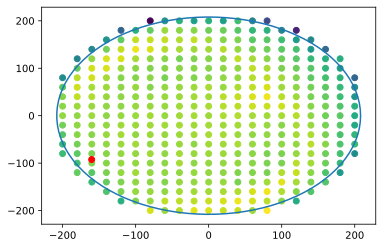

In [ ]:
z =12.5
sel = lt.z == z

sid = 6

plt.scatter(lt[sel].x, lt[sel].y, c=lt[sel][pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

# r = float(config.set_index("parameter").loc["ACTIVE_rad"])
r = 208
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

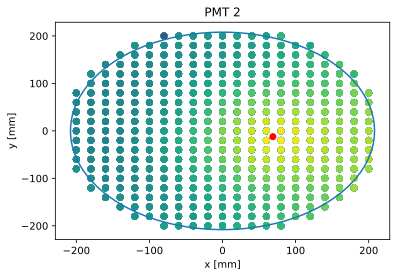

In [ ]:
sid = 2
plt.scatter(lt.x, lt.y, c=lt[pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(f"PMT {sid}")

# r = float(config.set_index("parameter").loc["ACTIVE_rad"])
r = 208
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

Text(0.5, 0.92, 'PMT 1')

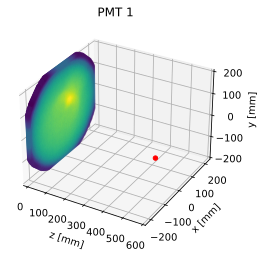

In [ ]:
sid = 1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter([520], [datapmt[datapmt["SensorID"]==sid].X.iloc[0]], [datapmt[datapmt["SensorID"]==sid].Y.iloc[0]], c="r")
ax.scatter(-10, lt.x, lt.y, c=lt[pmt + f"_{sid}"])
ax.set_zlim(-200, 200)
ax.set_xlim(-10, 600)
# ax.invert_xaxis()

ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_zlabel("y [mm]")
ax.set_title(f"PMT {sid}")


In [ ]:
from invisible_cities.core.core_functions import binedges_from_bincenters
# xbins = binedges_from_bincenters(np.unique(lt["x"]))
# ybins = binedges_from_bincenters(np.unique(lt["y"]))

In [ ]:
display(lt.head(10))

x     y      z  PmtR11410_0  PmtR11410_1  PmtR11410_2  PmtR11410_3  \
0 -200.0 -80.0   12.5     0.000525     0.000523     0.000539     0.000451   
1 -200.0 -80.0   37.5     0.000753     0.000759     0.000763     0.000609   
2 -200.0 -80.0   62.5     0.000843     0.000835     0.000822     0.000665   
3 -200.0 -80.0   87.5     0.000863     0.000849     0.000872     0.000680   
4 -200.0 -80.0  112.5     0.000902     0.000891     0.000914     0.000726   
5 -200.0 -80.0  137.5     0.000970     0.000961     0.000976     0.000767   
6 -200.0 -80.0  162.5     0.001021     0.001028     0.001033     0.000782   
7 -200.0 -80.0  187.5     0.001082     0.001083     0.001069     0.000823   
8 -200.0 -80.0  212.5     0.001098     0.001088     0.001113     0.000865   
9 -200.0 -80.0  237.5     0.001170     0.001159     0.001155     0.000884   

   PmtR11410_4  PmtR11410_5  PmtR11410_6  PmtR11410_7  PmtR11410_8  \
0     0.000494     0.000471     0.000453     0.000499     0.000476   
1     0.000648     0.000629     0.000596     0.000650     0.000646   
2     0.000690     0.000698     0.000659     0.000695     0.000682   
3     0.000729     0.000710     0.000670     0.000742     0.000698   
4     0.000764     0.000751     0.000700     0.000753     0.000743   
5     0.000796     0.000778     0.000762     0.000791     0.000772   
6     0.000824     0.000824     0.000787     0.000821     0.000800   
7     0.000853     0.000839     0.000825     0.000876     0.000833   
8     0.000858     0.000886     0.000856     0.000883     0.000867   
9     0.000912     0.000913     0.000905     0.000905     0.000885   

   PmtR11410_9  PmtR11410_10  PmtR11410_11  PmtR11410_total  
0     0.000425      0.000413      0.000418         0.005686  
1     0.000597      0.000582      0.000588         0.007819  
2     0.000652      0.000619      0.000624         0.008483  
3     0.000686      0.000669      0.000674         0.008842  
4     0.000707      0.000706      0.000694         0.009251  
5     0.000755      0.000759      0.000748         0.009835  
6     0.000791      0.000766      0.000777         0.010254  
7     0.000812      0.000801      0.000800         0.010696  
8     0.000832      0.000836      0.000829         0.011012  
9     0.000854      0.000850      0.000865         0.011458

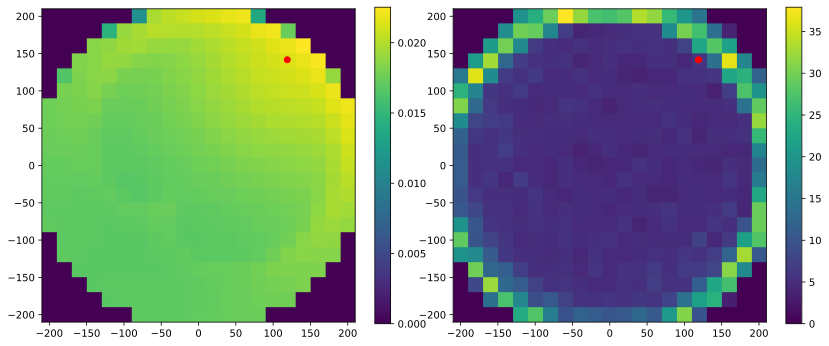

In [ ]:
sensor_id = 11

sensor_name = "PmtR11410_"+str(sensor_id)


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5])
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)

# light table
h, _, _ = np.histogram2d(lt["x"], lt["y"], weights=lt[sensor_name], bins=[xbins, ybins])
im0 = ax0.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im0, ax=ax0)

# err
h, _, _ = np.histogram2d(ERR["x"], ERR["y"], weights=ERR[sensor_name], bins=[xbins, ybins])
im1 = ax1.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im1, ax=ax1)

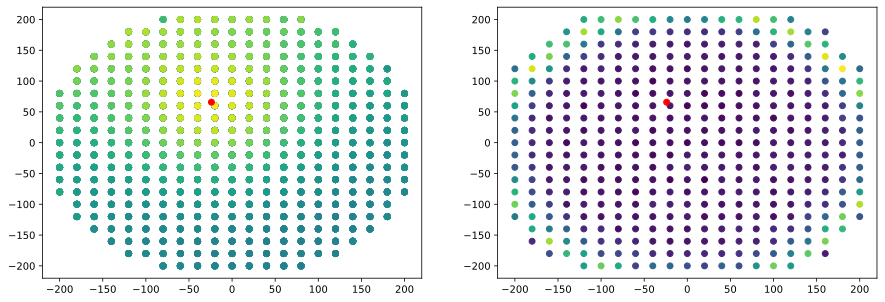

In [ ]:
sensor_id = 0

sensor_name = "PmtR11410_"+str(sensor_id)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_name])
ax1.scatter(ERR["x"], ERR["y"], c=ERR[sensor_name])

ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")

[ 12.5  37.5  62.5  87.5 112.5 137.5 162.5 187.5 212.5 237.5 262.5 287.5
 312.5 337.5 362.5 387.5 412.5 437.5 462.5 487.5 512.5]


/Users/mistryk2/opt/anaconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


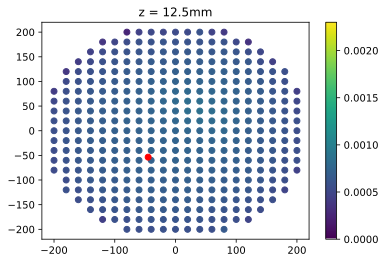

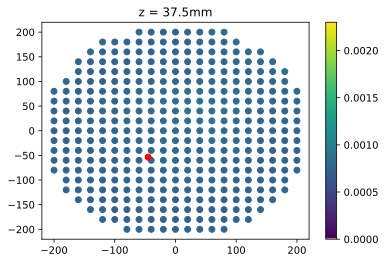

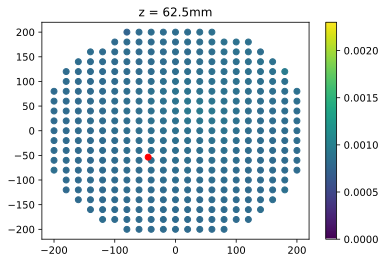

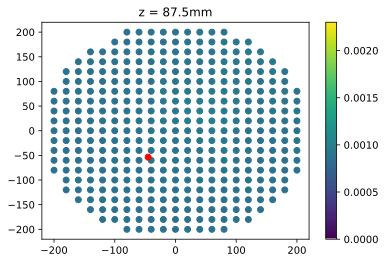

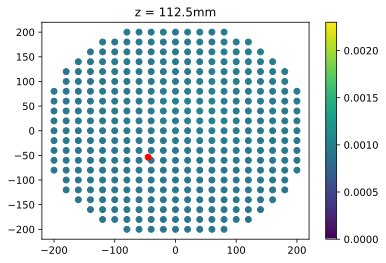

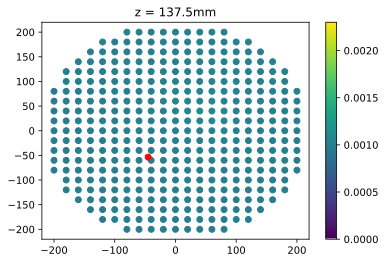

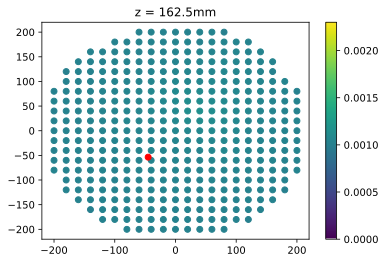

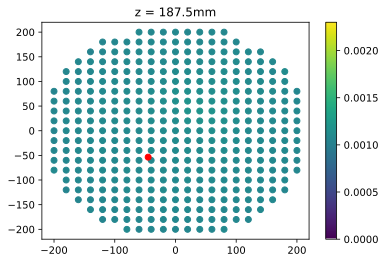

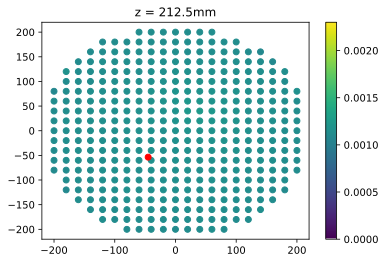

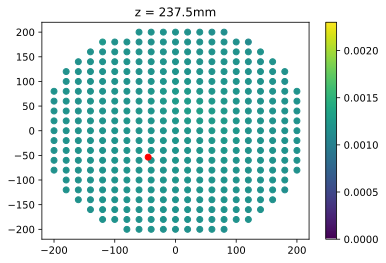

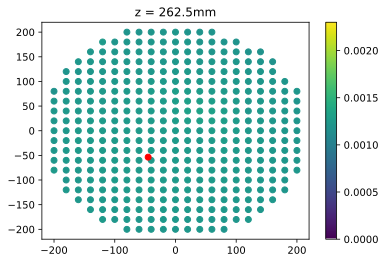

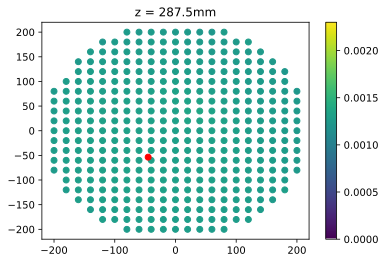

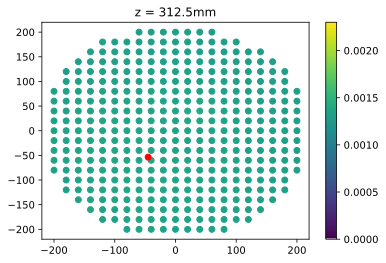

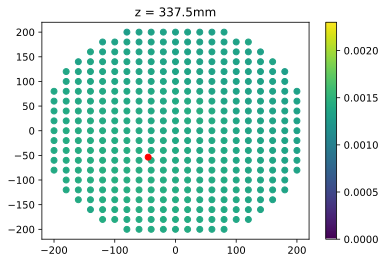

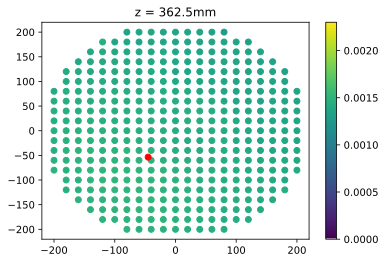

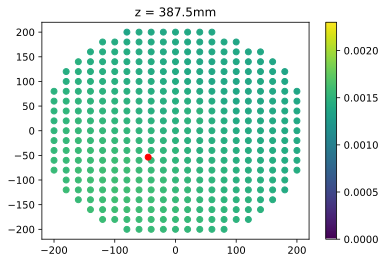

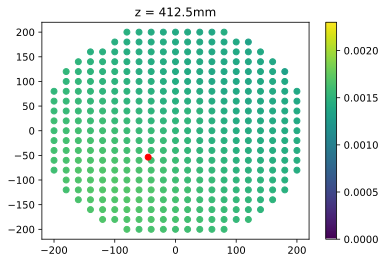

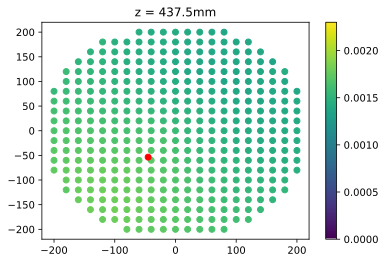

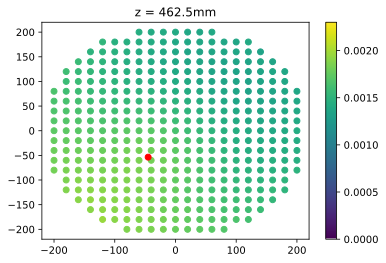

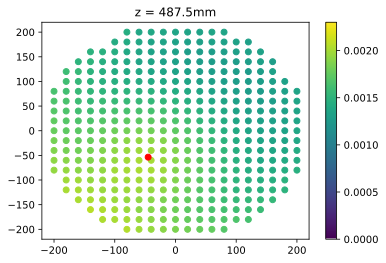

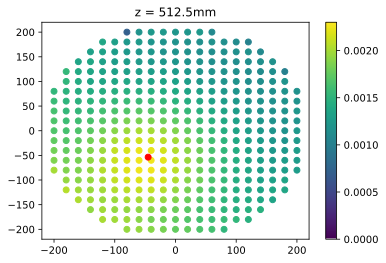

In [ ]:
# Plot the slices across all z bins

sensor_id = 1

sensor_name = "PmtR11410_"+str(sensor_id)


n = 4

print(lt.z.unique())

df = lt

for index, z in enumerate(df.z.unique()):
    # if (index >= n): break
    plt.figure()
    sel = df.z == z
    sc = plt.scatter(df[sel].x, df[sel].y, c=df[sel][pmt + f"_{sid}"], vmin = 0, vmax =0.0023)
    plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")
    plt.title(f"z = {z}mm")
    plt.colorbar(sc)
    plt.clim(0, 0.0015) 


